# IBM CAPSTONE PROJECT 

This kernel is part of my IBM Advanced Data Science Certification captsone project and will be crossposted to Kaggle (from where I obtained the data) and my GitHub. 

## Table of Contents 
1. Summary of Project 
2. ETL 
3. EDA/Feature Engineering
4. Modelling
5. Results
6. Conclusion
7. Additional Code

## 1. SUMMARY OF PROJECT

Can we predict whether or not a person will show up to a doctor's appointment? 

This project uses a dataset of patient appointments from spring/summer 2016 for a clinic in Vitoria, Brazil, obtained from Kaggle.com (https://www.kaggle.com/joniarroba/noshowappointments) Additional datasets (location of different neighborhoods in Vitoria, and weather on the day of the appointments) were obtained from google maps and historical weather data, respectively. 

After testing of several algorithms, XGBoost was chosen for this model as it performed the best for this dataset. 

The data are unbalanced (there are more people who showed up to appointments than people who didn't). To address this issue, appointment no-show data were oversampled. A stratified K fold was used to ensure that classes remain even on training (as an additional precaution). 

Logloss and Area under the Precision/Recall curve (AUPRC) were chosen as evaluation metrics. Logloss is useful for binary output and AUPRC will be sensitive to both precision and recall and will ideally find a good tradeoff between the two. 

While there was a relationship between features like age, number of prior visits, etc. and likelihood of a no-show. this model does not perform very well, despite testing with multiple algorithms, multiple evaluation metrics and feature combinations. We would ideally need more data on each appointment to better able to predict likelihood of a no-show. 

Examples of potentially useful data: patient income, number of family members of patient, home address, occupation, type of appointment (i.e. follow up, consultation, the medical concern to be addressed at the appointment, etc.), which doctor the appointment was with, location of clinic (are the data coming from one clinic or multiple across the city?), hour of appointment (noticeably absent from the AppointmentDay feature), prior appointment history with the clinic, etc. 

## 2. ETL 

Now on to the actual modelling. First, I will import all the libraries used through the modelling process in addition to the initial dataset, obtained from Kaggle.com

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
from heapq import nlargest, nsmallest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import auc, log_loss, f1_score, confusion_matrix, precision_recall_curve

In [2]:
df=pd.read_csv('KaggleV2-May-2016.csv')
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## 3. EDA/FEATURE ENGINEERING

Now it's time to do some feature exploration and engineering. Looking at the description of the data below, a few things jump out: firstly, while things like diabetes, hypertension, etc. are binary columns, handicap is not. This column seems to measure the number of handicaps someone has rather than whether or not they have a handicap. 

In addition, the minimum age is -1 and the maximum age is 115. There is no way to interpret the -1, so it will be removed from the dataset. 

Let's investigate the ten appointments with the oldest clients. 

In [3]:
nlargest(10, df['Age'])

[115, 115, 115, 115, 115, 102, 102, 100, 100, 100]

After a little investigation, there are very few people who have reached 115 years old, and I could find none that lived in Brazil. To avoid skewing the rest of the data, we will limit the age to 102 (the next oldest patients). 

Now let's take a look at how the dataset looks like

In [4]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Now let's see how these features are structured, and whether there are any missing data.

In [5]:
for x in df:
    print(x, 'nums: ',df[x].nunique())
    print(x, 'NAN: ', df[x].isnull().sum())

PatientId nums:  62299
PatientId NAN:  0
AppointmentID nums:  110527
AppointmentID NAN:  0
Gender nums:  2
Gender NAN:  0
ScheduledDay nums:  103549
ScheduledDay NAN:  0
AppointmentDay nums:  27
AppointmentDay NAN:  0
Age nums:  104
Age NAN:  0
Neighbourhood nums:  81
Neighbourhood NAN:  0
Scholarship nums:  2
Scholarship NAN:  0
Hipertension nums:  2
Hipertension NAN:  0
Diabetes nums:  2
Diabetes NAN:  0
Alcoholism nums:  2
Alcoholism NAN:  0
Handcap nums:  5
Handcap NAN:  0
SMS_received nums:  2
SMS_received NAN:  0
No-show nums:  2
No-show NAN:  0


There are no missing values, so we will not have to worry about that. 

- Some patients had multiple appointments within this dataset; this will need to be investigated further
- The 'AppointmentID' feature is unique and will therefore be excluded from the final model. 
- There are 81 neighbourhoods. I will therefore not create binary dummy variables for this feature, as it will create too many features. 

Everything else looks reasonable. 

Next, let's look at the date range of the 'ScheduledDay' and 'AppointmentDay' features:


In [6]:
print(max(df['ScheduledDay']))
print(min(df['ScheduledDay']))

print(max(df['AppointmentDay']))
print(min(df['AppointmentDay']))

2016-06-08T20:07:23Z
2015-11-10T07:13:56Z
2016-06-08T00:00:00Z
2016-04-29T00:00:00Z


It seems that all the appointmnets happen within the span of ~ 1.5 months. Meanwhile, sime if these appointments are being scheduled far in advance. 

Let's ensure that these 2015 ScheduledDay values are not complete outliers: 

In [7]:
nsmallest(100, df['ScheduledDay'])

['2015-11-10T07:13:56Z',
 '2015-12-03T08:17:28Z',
 '2015-12-07T10:40:59Z',
 '2015-12-07T10:42:42Z',
 '2015-12-07T10:43:01Z',
 '2015-12-07T10:43:17Z',
 '2015-12-07T10:43:34Z',
 '2015-12-07T10:43:50Z',
 '2015-12-07T10:44:07Z',
 '2015-12-07T10:44:25Z',
 '2015-12-07T10:44:40Z',
 '2015-12-07T10:45:01Z',
 '2015-12-08T13:30:21Z',
 '2015-12-08T13:30:41Z',
 '2015-12-08T13:31:04Z',
 '2015-12-08T13:31:21Z',
 '2015-12-08T13:31:45Z',
 '2015-12-08T13:32:14Z',
 '2015-12-08T13:32:34Z',
 '2015-12-08T13:33:09Z',
 '2015-12-08T13:33:28Z',
 '2015-12-08T13:33:50Z',
 '2015-12-08T13:58:50Z',
 '2015-12-08T13:59:33Z',
 '2015-12-08T14:00:52Z',
 '2015-12-08T14:01:28Z',
 '2015-12-08T14:02:04Z',
 '2015-12-08T14:02:31Z',
 '2015-12-08T14:03:00Z',
 '2015-12-08T14:03:23Z',
 '2015-12-08T14:03:40Z',
 '2015-12-08T14:04:28Z',
 '2015-12-08T14:05:35Z',
 '2015-12-08T14:18:39Z',
 '2015-12-08T14:19:05Z',
 '2015-12-08T14:20:08Z',
 '2015-12-08T14:20:56Z',
 '2015-12-08T14:23:47Z',
 '2015-12-08T14:24:30Z',
 '2015-12-08T14:24:54Z',


While relatively sparse, these 2015 dates are not complete outliers. I will not remove them. 

Let's look at the structure of all schedule days to make sure: 

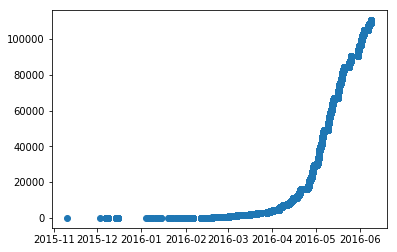

In [8]:
plt.plot_date(matplotlib.dates.date2num((df['ScheduledDay'].sort_values())
        .apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))), range(len(df)))

While a few gaps exist, these schedule dates from winter 2015/2016 are not that unusual. 

Will now remove age outliers:

In [9]:
df=df[df['Age'] >= 0][df['Age']<105].reset_index(drop=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


To do better feature exploration (and prepare for modelling), need to alter features. Firstly, I will label encode the two binary features not yet in numerical form: gender and no-show. 

In [10]:
for x in ['Gender','No-show']:
    labelenc=LabelEncoder()
    df[x]=labelenc.fit_transform(df[x])

Next, I will convert the ScheduledDay and AppointmentDay features into Datetime objects and extract meaningful information, including day of week and day of year. I will also calcualte the days elapsed between schedule and appointment dates for analysis. 

In [11]:
df['ScheduledDay']=df['ScheduledDay'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
df['AppointmentDay']=df['AppointmentDay'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))

df['Sched_Year']=df['ScheduledDay'].apply(lambda x: x.year)
df['Sched_Month']=df['ScheduledDay'].apply(lambda x: x.month)
df['Sched_Day']=df['ScheduledDay'].apply(lambda x: x.day)
df['Sched_Hr']=df['ScheduledDay'].apply(lambda x: x.hour)
df['Sched_WeekDay']=df['ScheduledDay'].apply(lambda x: x.isoweekday())
df['Sched_WeekofYr']=df['ScheduledDay'].apply(lambda x: x.strftime('%W'))
df['Sched_DayofYr']=df['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)

df['App_Year']=df['AppointmentDay'].apply(lambda x: x.year)
df['App_Month']=df['AppointmentDay'].apply(lambda x: x.month)
df['App_Day']=df['AppointmentDay'].apply(lambda x: x.day)
df['App_WeekDay']=df['AppointmentDay'].apply(lambda x: x.isoweekday())
df['App_WeekofYr']=df['AppointmentDay'].apply(lambda x: x.strftime('%W'))
df['App_DayofYr']=df['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

#need to round up since no hrs for appointment day 
df['Days_Elapsed']=((df['AppointmentDay']-df['ScheduledDay'])
        .apply(lambda x: x.total_seconds())/86400).apply(lambda x: math.ceil(x))

I will now encode how many times each patient scheduled an appointment, the frequency with which patients came from the different neighbourhoods of Vitoria, the latitude/longitude of each Vitoria neighbourhood (to retain as much information as possible), as well as weather the day of the appointment. 

In [12]:
patient_freq=df['PatientId'].value_counts()
patient_freq=patient_freq.reset_index()
patient_freq.columns=['PatientId','Patient_Freq']

df=df.merge(patient_freq, on='PatientId', how='left')

In [13]:
latlong=pd.read_csv('lat_long.csv', encoding='latin')
area=df.groupby('Neighbourhood').count()['AppointmentID']
area=area.reset_index()
area.columns=['Neighbourhood','freq_area']

df=df.merge(area, on='Neighbourhood',how='left')

df=df.merge(latlong, left_on='Neighbourhood',right_on='Region',how='left')

In [14]:
weather=pd.read_csv('weather.csv')    
weather['AppointmentDay']=weather['AppointmentDay'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))


df=df.merge(weather, on='AppointmentDay',how='left')

condition=pd.get_dummies(df['Condition'], drop_first=True)

df=pd.concat([df,condition],axis=1)

Here is what our dataset looks like now: 

In [15]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,freq_area,Region,Lat,Long,High,Low,Condition,overcast,rain,sunny
0,2.987250e+13,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,3877,JARDIM DA PENHA,-20.283371,-40.294036,15,14,fog,0,0,0
1,5.589978e+14,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,3877,JARDIM DA PENHA,-20.283371,-40.294036,15,14,fog,0,0,0
2,4.262962e+12,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,644,MATA DA PRAIA,-20.276215,-40.290514,15,14,fog,0,0,0
3,8.679512e+11,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,69,PONTAL DE CAMBURI,-20.288505,-40.299206,15,14,fog,0,0,0
4,8.841186e+12,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,3877,JARDIM DA PENHA,-20.283371,-40.294036,15,14,fog,0,0,0


Now for some feature exploration. I will first look at the distribution of key features and their relation to no-shows.

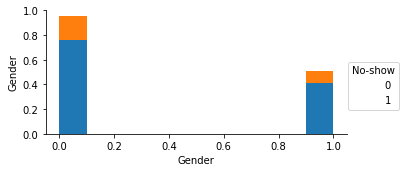

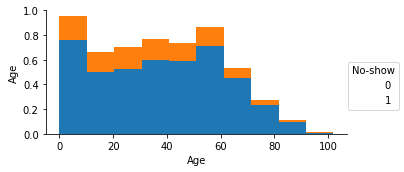

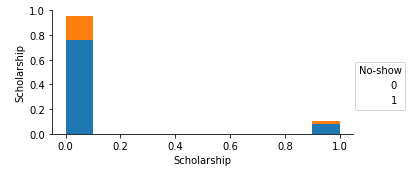

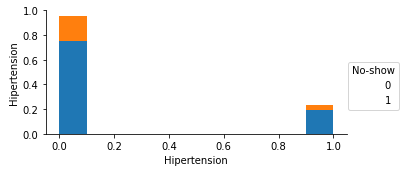

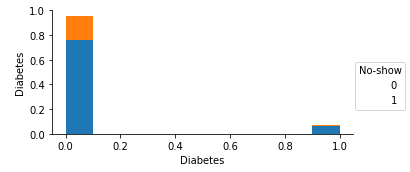

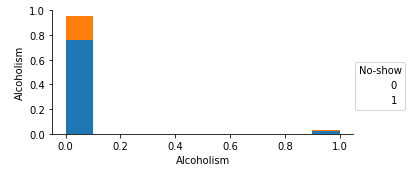

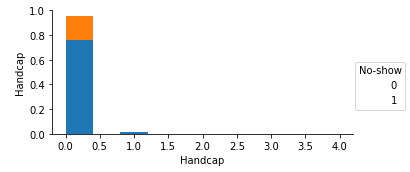

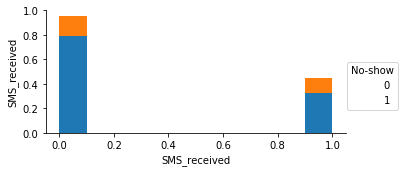

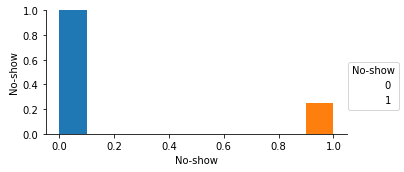

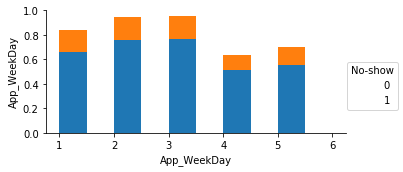

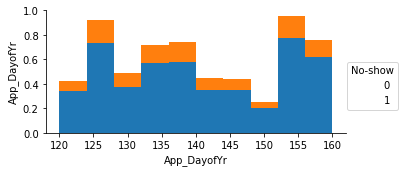

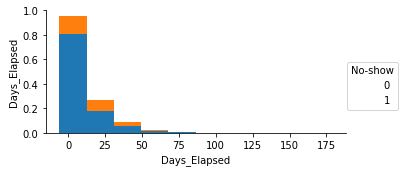

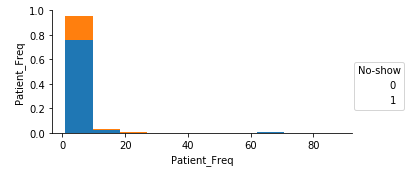

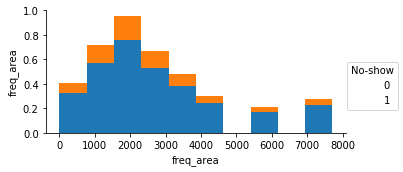

In [16]:
for x in ['Gender', 'Age','Scholarship', 'Hipertension', 'Diabetes','Alcoholism','Handcap','SMS_received',
          'No-show','App_WeekDay','App_DayofYr','Days_Elapsed', 'Patient_Freq', 'freq_area']:
    sns.pairplot(data=df, vars=[x], hue='No-show', aspect=2)

Some insights: 

- more women go to doctor 
- more babies and people in their 50's go to doctor 
- scholarship, Hypertension, Diabetes and Alcoholism are relatively low among population
- very few people have a handicap, particularly more than one 
- many people receive SMS about ther appointments
- no shows are relatively low; will need to consider this when training model, as the dataset is uneven
- some Saturday appointments exist, but not that may; most are Mon-Wed 
- most appointments happen within 25 days of booking 

now let's look at a number of key features in relation to gender: 

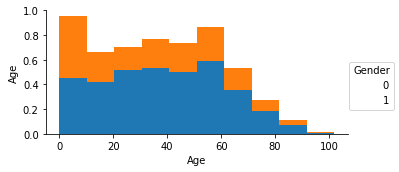

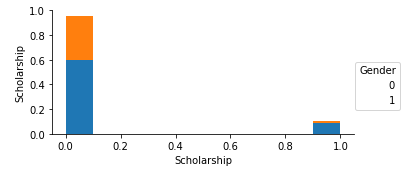

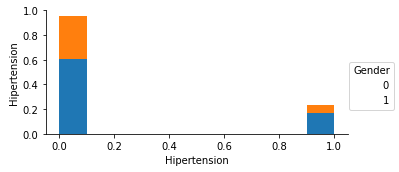

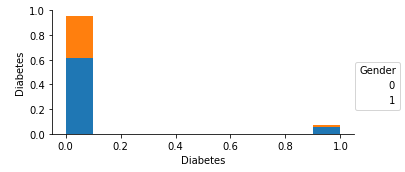

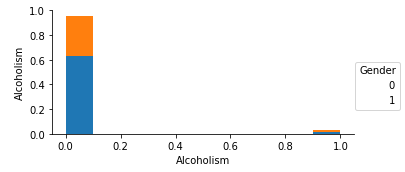

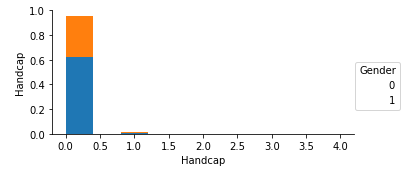

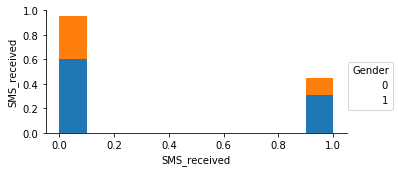

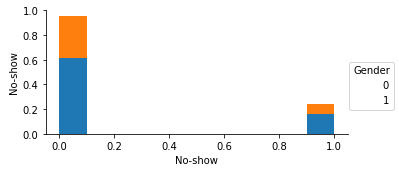

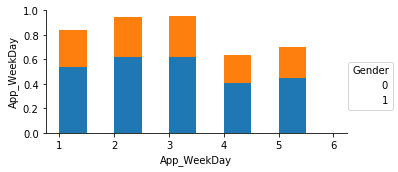

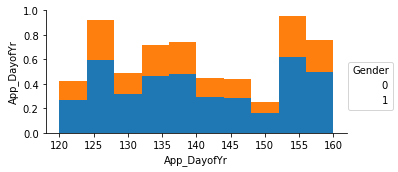

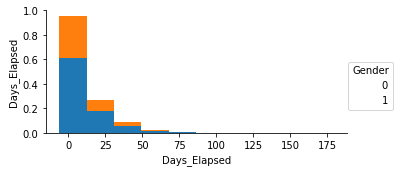

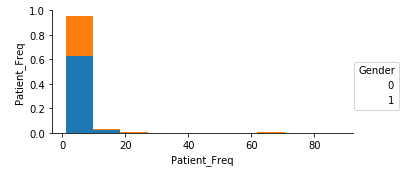

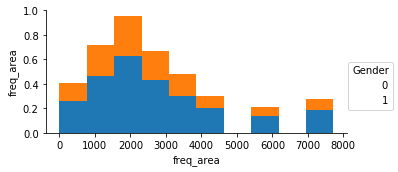

In [17]:
for x in ['Age','Scholarship', 'Hipertension', 'Diabetes','Alcoholism','Handcap','SMS_received',
          'No-show','App_WeekDay','App_DayofYr','Days_Elapsed', 'Patient_Freq', 'freq_area']:
    sns.pairplot(data=df, vars=[x], hue='Gender', aspect=2)

There is nothing too significant, suggesting that while women go to the clinic more often, there may not be any really strong pattern with measured features beyond that.

Now let's look at a weighted visualization that takes into account imbalances in different features: 

Gender


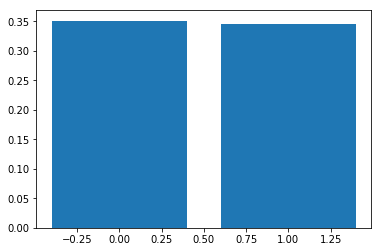

Scholarship


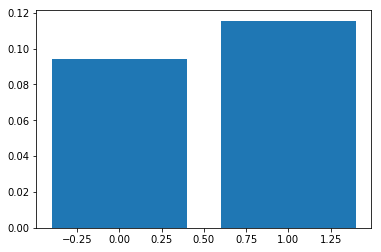

Hipertension


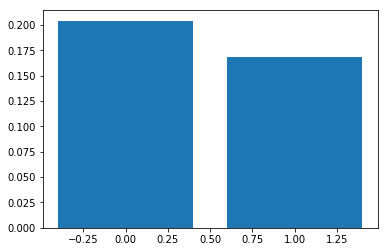

Diabetes


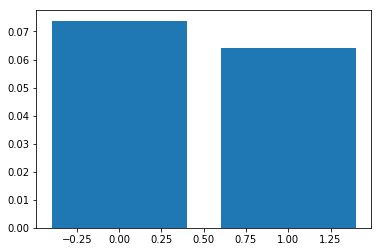

Alcoholism


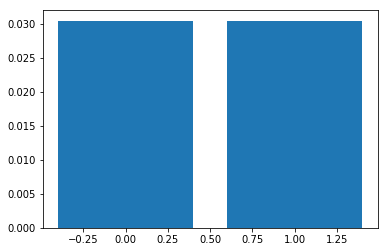

Handcap


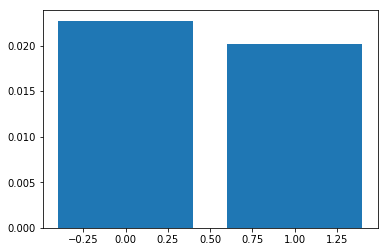

SMS_received


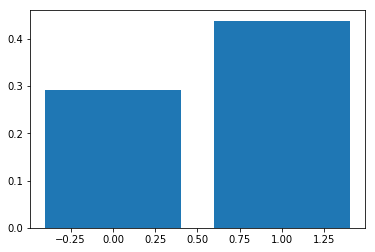

Days_Elapsed


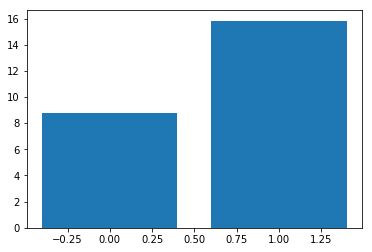

In [18]:
stats_noshow=df.groupby('No-show').mean()

for x in ['Gender','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap',
          'SMS_received','Days_Elapsed']:
    print(x)
    plt.bar([0,1],stats_noshow[x])
    plt.show()


Key insights: 

- no trend in gender, like previously suspected 
- slightly more likley to miss appointment with scholarship
- more likely to attend appointment if patient has hypertension, diabetes and a handicap
- less likely to attend appointment if sms recieved  

Now look at spatial distribution:

In [19]:
stats_latlong=df.groupby('Long').mean()
stats_latlong=stats_latlong.drop([df['Long'].max(), df['Long'].min()],axis=0)

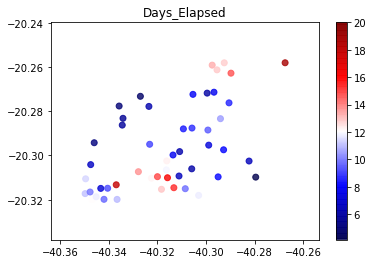

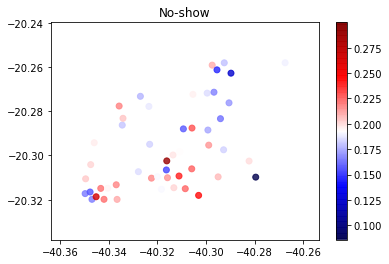

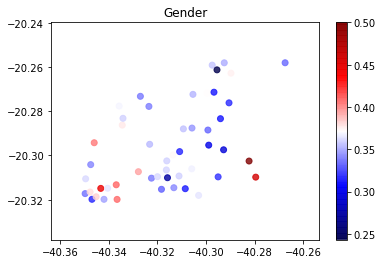

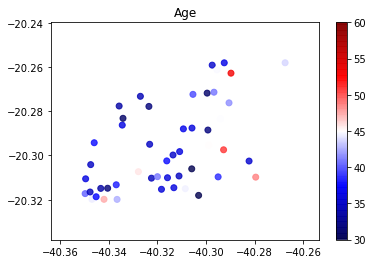

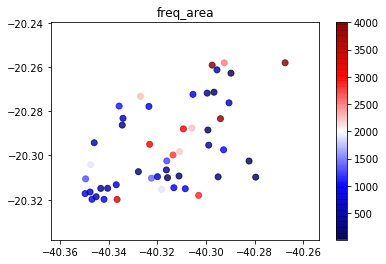

In [20]:
vmax={'Days_Elapsed':20,'No-show':0.3, 'Gender':0.5,'Age':60, 'freq_area':4000}

for x in ['Days_Elapsed','No-show','Gender','Age','freq_area']:
    plt.scatter(stats_latlong.index, stats_latlong['Lat'],c=stats_latlong[x], 
            cmap='seismic', alpha=0.8, vmax=vmax[x])
    plt.title(x)
    plt.colorbar()
    plt.show()


There are some interesting data here; it is difficult to obtain more insight from these data without more context about these neighbourhoods, income levels, occupation, clinic location, etc. 

Now let's look at age

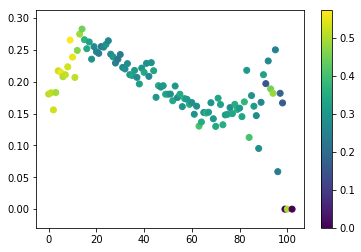

In [21]:
stats_age=df.groupby('Age').mean()

plt.scatter(stats_age.index, stats_age['No-show'], c=stats_age['Gender'])
plt.colorbar()

Key insights: 

- no-show peak at around ~20 yrs old, and then decreases until around 80
- the most even gender distribution is in the young years, after that, it is predominantly women 

Now look at the relationship between no-shows and days elapsed between schedule and appointment days: 

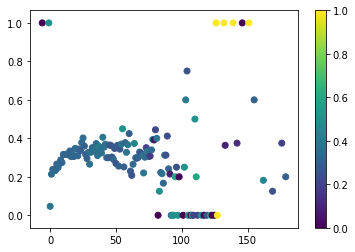

In [22]:
stats_days=df.groupby('Days_Elapsed').mean()

plt.scatter(stats_days.index, stats_days['No-show'], c=stats_days['Gender'])
plt.colorbar()

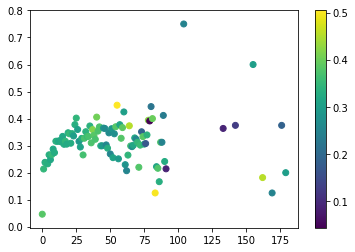

In [23]:
stats_days=stats_days.drop(df.groupby('Days_Elapsed').count()[df.groupby('Days_Elapsed').count()['No-show'] < 6]
            .index.values, axis=0)

plt.scatter(stats_days.index, stats_days['No-show'], c=stats_days['Gender'])
plt.colorbar()

After some cleaning up of outliers, there does seem to be a pattern here: patient is more likely to come to appointment if scheduled close to appointment date; this likelihood drops as the time elapsed between schedule and appointment date rises to ~25 days. After 25 days, it is much more difficult to predict. 

What is the relationship between patient frequency and no-shows

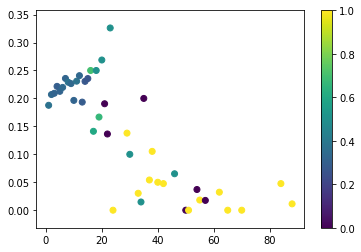

In [24]:
stats_freq=df.groupby('Patient_Freq').mean()
plt.scatter(stats_freq.index, stats_freq['No-show'], c=stats_freq['Gender'])
plt.colorbar()

There seems to be a pretty strong negative correlation between the number of times a patient visits the clinic and the likihood of a no-show. 

What about weather: 

In [25]:
stats_weather=df.groupby('Condition').mean()
stats_weather


,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,Days_Elapsed,Patient_Freq,freq_area,Lat,Long,High,Low,overcast,rain,sunny
Condition,,,,,,,,,,,,,,,,,,,,,
fog,1.464124e+14,5.681531e+06,0.343092,36.352503,0.095543,0.195007,0.075938,0.029277,0.022742,0.445040,...,10.795974,3.238923,2629.104039,-20.290918,-40.310880,16.731538,15.731538,0,0,0
overcast,1.474978e+14,5.670477e+06,0.348574,37.147168,0.098034,0.199167,0.072725,0.030543,0.021924,0.207161,...,9.721703,3.567010,2721.500456,-20.289952,-40.310363,18.780654,16.567244,1,0,0
rain,1.485719e+14,5.679981e+06,0.356349,36.753582,0.092515,0.187871,0.068552,0.031374,0.026062,0.000000,...,10.239007,3.827816,2722.042737,-20.290016,-40.309838,17.472826,16.472826,0,1,0
sunny,1.474798e+14,5.677075e+06,0.351079,37.191027,0.099629,0.197591,0.071209,0.030318,0.021785,0.427895,...,10.407458,3.522415,2733.691799,-20.289940,-40.310451,21.261527,17.439497,0,0,1


<BarContainer object of 4 artists>

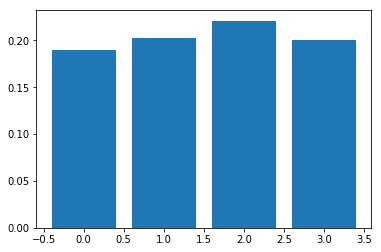

In [26]:
plt.bar([0,1,2,3], stats_weather['No-show'])

People are less likely to show up if it is raining. 

What about temperature: 

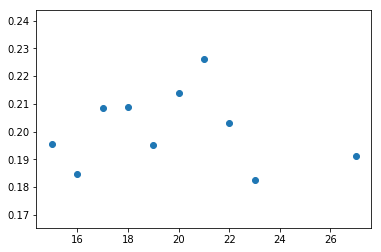

In [27]:
stats_weather=df.groupby('High').mean()
plt.scatter(stats_weather.index, stats_weather['No-show'])

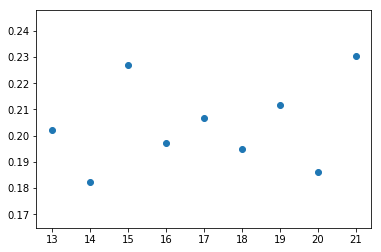

In [28]:
stats_weather=df.groupby('Low').mean()
plt.scatter(stats_weather.index, stats_weather['No-show'])

There doesn't seem to be much relation. 

Overall, there seems to be a pretty clear relationship between age and no-shows, and patient frequency and no-shows. There also seems to be at least a mild relationship between no-shows and most other features. 

Before we put our dataset into an algorithm, a few last things to consider. 

We previously looked at the day of the week when the appointment happened and noticed very few appointments occured on saturday. Let's get more detail on these Saturday appointments. 

In [29]:
df[df['App_WeekDay']==6]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,freq_area,Region,Lat,Long,High,Low,Condition,overcast,rain,sunny
72292,9.656744e+12,5647188,0,2016-05-02 13:08:18,2016-05-14,60,SANTO ANTÔNIO,0,0,0,...,2746,NaN,NaN,NaN,18,16,overcast,1,0,0
72293,2.612468e+14,5692771,1,2016-05-12 16:13:24,2016-05-14,56,CARATOÍRA,0,0,0,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0
72294,6.219718e+13,5668696,0,2016-05-06 09:35:30,2016-05-14,27,CARATOÍRA,1,0,0,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0
72295,1.715928e+12,5646878,1,2016-05-02 12:02:42,2016-05-14,75,CARATOÍRA,0,1,1,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0
72296,6.182446e+13,5673055,0,2016-05-09 08:50:55,2016-05-14,67,CARATOÍRA,0,0,0,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0
72297,4.494622e+12,5674445,0,2016-05-09 11:04:56,2016-05-14,72,CARATOÍRA,0,1,1,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0
72298,6.355623e+13,5674448,1,2016-05-09 11:05:15,2016-05-14,52,CARATOÍRA,0,0,1,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0
72299,5.967117e+13,5646085,1,2016-05-02 10:49:40,2016-05-14,31,ARIOVALDO FAVALESSA,0,0,0,...,282,ARIOVALDO FAVALESSA,-20.314673,-40.356391,18,16,overcast,1,0,0
72300,6.716769e+13,5646088,0,2016-05-02 10:49:54,2016-05-14,52,ARIOVALDO FAVALESSA,0,0,0,...,282,ARIOVALDO FAVALESSA,-20.314673,-40.356391,18,16,overcast,1,0,0
72301,7.367167e+12,5678814,0,2016-05-10 09:06:06,2016-05-14,58,CARATOÍRA,0,0,0,...,2565,NaN,NaN,NaN,18,16,overcast,1,0,0


All of these saturday appointments are on the same day. They will therefore be treated as outliers and removed. 

I will also delete patients that come from neighbourhoods from which people do not visit often. 

In [30]:
df=df[df['App_WeekDay']!=6]

df=df[df['freq_area']>2]

## 4. MODELLING

Now to the model. XGBoost was chosen after test runs with several algorithms.

A number of features that do not provide much information will be dropped. and the data will be split into train/test datasets. 

Scaling was omitted from this model as XGBoost with a tree-based learning objective is not sensitive to magnitude. 

On the second iteration, to address the imbalance in results (only ~20% of data are no-shows), we will oversample the training data create better balance between the two options. (undersampling was also attempted, but did not perform as well). 

On the second iteration, to avoid over-fitting, a slow learning rate was chosen and the training was split over 3 folds. 
A stratified K-Fold was used to ensure that classes stay relatively even throughout the training process. 

Area under precision-recall curve (AUPRC) and logloss were chosen as evaluation metrics. Logloss is good for classification and deals well with unbalanced data while AUPRC tries to balance both precision and recall, attempting to avoid too many false negatives and false positives. 

In [31]:
df_final=df.drop(['ScheduledDay','AppointmentDay','Neighbourhood','Region','Condition'],axis=1)
df_final.head()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,Days_Elapsed,Patient_Freq,freq_area,Lat,Long,High,Low,overcast,rain,sunny
0,2.987250e+13,5642903,0,62,0,1,0,0,0,0,...,0,2,3877,-20.283371,-40.294036,15,14,0,0,0
1,5.589978e+14,5642503,1,56,0,0,0,0,0,0,...,0,2,3877,-20.283371,-40.294036,15,14,0,0,0
2,4.262962e+12,5642549,0,62,0,0,0,0,0,0,...,0,2,644,-20.276215,-40.290514,15,14,0,0,0
3,8.679512e+11,5642828,0,8,0,0,0,0,0,0,...,0,2,69,-20.288505,-40.299206,15,14,0,0,0
4,8.841186e+12,5642494,0,56,0,1,1,0,0,0,...,0,1,3877,-20.283371,-40.294036,15,14,0,0,0


In [32]:
x=df_final.drop(['PatientId','AppointmentID','No-show','Sched_Year','Sched_Month','Sched_Day','App_Year'],axis=1)
y=df_final['No-show']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_train=x_train.values.astype(float)
x_test=x_test.values.astype(float)
y_train=y_train.values
y_test=y_test.values

Model iteration 1

In [34]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)

xgb_pred=[]
xgb = XGBClassifier(n_estimators=1000, objective='binary:logistic',eval_metric=['aucpr','logloss'], 
                    verbose=1, early_stopping_rounds=200)

for train_index, test_index in kf.split(x_train, y_train):
    xk_train, x_valid = x_train[train_index], x_train[test_index]
    yk_train, y_valid = y_train[train_index], y_train[test_index]


    xgb.fit(xk_train, yk_train, verbose=True, eval_set=[(x_valid,y_valid)])

    xgb_pred.append(xgb.predict_proba(x_test))

[0]	validation_0-aucpr:0.334216	validation_0-logloss:0.65302
[1]	validation_0-aucpr:0.335346	validation_0-logloss:0.620238
[2]	validation_0-aucpr:0.336898	validation_0-logloss:0.593179
[3]	validation_0-aucpr:0.336874	validation_0-logloss:0.570561
[4]	validation_0-aucpr:0.336881	validation_0-logloss:0.551599
[5]	validation_0-aucpr:0.337393	validation_0-logloss:0.53555
[6]	validation_0-aucpr:0.345637	validation_0-logloss:0.521911
[7]	validation_0-aucpr:0.347166	validation_0-logloss:0.51035
[8]	validation_0-aucpr:0.348438	validation_0-logloss:0.500394
[9]	validation_0-aucpr:0.34855	validation_0-logloss:0.491896
[10]	validation_0-aucpr:0.349507	validation_0-logloss:0.484614
[11]	validation_0-aucpr:0.357285	validation_0-logloss:0.478171
[12]	validation_0-aucpr:0.357561	validation_0-logloss:0.472761
[13]	validation_0-aucpr:0.359555	validation_0-logloss:0.467962
[14]	validation_0-aucpr:0.358949	validation_0-logloss:0.463933
[15]	validation_0-aucpr:0.358904	validation_0-logloss:0.460438
[16]	v

[130]	validation_0-aucpr:0.384369	validation_0-logloss:0.432666
[131]	validation_0-aucpr:0.384396	validation_0-logloss:0.432661
[132]	validation_0-aucpr:0.384445	validation_0-logloss:0.432654
[133]	validation_0-aucpr:0.384492	validation_0-logloss:0.432649
[134]	validation_0-aucpr:0.384583	validation_0-logloss:0.432643
[135]	validation_0-aucpr:0.384533	validation_0-logloss:0.432631
[136]	validation_0-aucpr:0.384616	validation_0-logloss:0.432608
[137]	validation_0-aucpr:0.384914	validation_0-logloss:0.432556
[138]	validation_0-aucpr:0.384873	validation_0-logloss:0.432535
[139]	validation_0-aucpr:0.385021	validation_0-logloss:0.432527
[140]	validation_0-aucpr:0.385122	validation_0-logloss:0.432513
[141]	validation_0-aucpr:0.385059	validation_0-logloss:0.432503
[142]	validation_0-aucpr:0.384909	validation_0-logloss:0.432518
[143]	validation_0-aucpr:0.385021	validation_0-logloss:0.432502
[144]	validation_0-aucpr:0.385079	validation_0-logloss:0.43249
[145]	validation_0-aucpr:0.385	validation

[259]	validation_0-aucpr:0.391964	validation_0-logloss:0.431343
[260]	validation_0-aucpr:0.391783	validation_0-logloss:0.43135
[261]	validation_0-aucpr:0.3918	validation_0-logloss:0.431351
[262]	validation_0-aucpr:0.391627	validation_0-logloss:0.431357
[263]	validation_0-aucpr:0.391615	validation_0-logloss:0.431353
[264]	validation_0-aucpr:0.392159	validation_0-logloss:0.431299
[265]	validation_0-aucpr:0.392159	validation_0-logloss:0.431288
[266]	validation_0-aucpr:0.392314	validation_0-logloss:0.431273
[267]	validation_0-aucpr:0.392431	validation_0-logloss:0.431244
[268]	validation_0-aucpr:0.392512	validation_0-logloss:0.431248
[269]	validation_0-aucpr:0.39263	validation_0-logloss:0.431237
[270]	validation_0-aucpr:0.392992	validation_0-logloss:0.431189
[271]	validation_0-aucpr:0.393378	validation_0-logloss:0.431153
[272]	validation_0-aucpr:0.393355	validation_0-logloss:0.431138
[273]	validation_0-aucpr:0.39339	validation_0-logloss:0.431135
[274]	validation_0-aucpr:0.393435	validation_

[388]	validation_0-aucpr:0.397412	validation_0-logloss:0.430381
[389]	validation_0-aucpr:0.397418	validation_0-logloss:0.430377
[390]	validation_0-aucpr:0.397393	validation_0-logloss:0.430379
[391]	validation_0-aucpr:0.397379	validation_0-logloss:0.430358
[392]	validation_0-aucpr:0.397602	validation_0-logloss:0.430349
[393]	validation_0-aucpr:0.397612	validation_0-logloss:0.430348
[394]	validation_0-aucpr:0.397765	validation_0-logloss:0.430324
[395]	validation_0-aucpr:0.397896	validation_0-logloss:0.430329
[396]	validation_0-aucpr:0.397906	validation_0-logloss:0.430325
[397]	validation_0-aucpr:0.397851	validation_0-logloss:0.430327
[398]	validation_0-aucpr:0.397941	validation_0-logloss:0.430298
[399]	validation_0-aucpr:0.398087	validation_0-logloss:0.430297
[400]	validation_0-aucpr:0.39814	validation_0-logloss:0.430279
[401]	validation_0-aucpr:0.398157	validation_0-logloss:0.430297
[402]	validation_0-aucpr:0.398229	validation_0-logloss:0.430292
[403]	validation_0-aucpr:0.398316	validat

[517]	validation_0-aucpr:0.39959	validation_0-logloss:0.430043
[518]	validation_0-aucpr:0.399595	validation_0-logloss:0.43004
[519]	validation_0-aucpr:0.399501	validation_0-logloss:0.430037
[520]	validation_0-aucpr:0.399426	validation_0-logloss:0.430018
[521]	validation_0-aucpr:0.399405	validation_0-logloss:0.430022
[522]	validation_0-aucpr:0.399379	validation_0-logloss:0.430024
[523]	validation_0-aucpr:0.399328	validation_0-logloss:0.430027
[524]	validation_0-aucpr:0.399423	validation_0-logloss:0.430034
[525]	validation_0-aucpr:0.399517	validation_0-logloss:0.430029
[526]	validation_0-aucpr:0.399495	validation_0-logloss:0.430036
[527]	validation_0-aucpr:0.399485	validation_0-logloss:0.430034
[528]	validation_0-aucpr:0.399662	validation_0-logloss:0.430015
[529]	validation_0-aucpr:0.399529	validation_0-logloss:0.430042
[530]	validation_0-aucpr:0.39942	validation_0-logloss:0.430051
[531]	validation_0-aucpr:0.399395	validation_0-logloss:0.430049
[532]	validation_0-aucpr:0.399347	validatio

[646]	validation_0-aucpr:0.399632	validation_0-logloss:0.43005
[647]	validation_0-aucpr:0.399622	validation_0-logloss:0.43007
[648]	validation_0-aucpr:0.399655	validation_0-logloss:0.43007
[649]	validation_0-aucpr:0.39966	validation_0-logloss:0.430076
[650]	validation_0-aucpr:0.399629	validation_0-logloss:0.430079
[651]	validation_0-aucpr:0.39961	validation_0-logloss:0.43008
[652]	validation_0-aucpr:0.399656	validation_0-logloss:0.430081
[653]	validation_0-aucpr:0.399585	validation_0-logloss:0.430082
[654]	validation_0-aucpr:0.399808	validation_0-logloss:0.430052
[655]	validation_0-aucpr:0.399877	validation_0-logloss:0.430057
[656]	validation_0-aucpr:0.399827	validation_0-logloss:0.430064
[657]	validation_0-aucpr:0.399874	validation_0-logloss:0.430061
[658]	validation_0-aucpr:0.399767	validation_0-logloss:0.430066
[659]	validation_0-aucpr:0.399789	validation_0-logloss:0.430064
[660]	validation_0-aucpr:0.399791	validation_0-logloss:0.430073
[661]	validation_0-aucpr:0.399752	validation_0

[775]	validation_0-aucpr:0.399896	validation_0-logloss:0.430092
[776]	validation_0-aucpr:0.399981	validation_0-logloss:0.430074
[777]	validation_0-aucpr:0.399931	validation_0-logloss:0.430094
[778]	validation_0-aucpr:0.399932	validation_0-logloss:0.430092
[779]	validation_0-aucpr:0.399865	validation_0-logloss:0.430101
[780]	validation_0-aucpr:0.399871	validation_0-logloss:0.430093
[781]	validation_0-aucpr:0.399867	validation_0-logloss:0.430092
[782]	validation_0-aucpr:0.399854	validation_0-logloss:0.430091
[783]	validation_0-aucpr:0.399864	validation_0-logloss:0.430101
[784]	validation_0-aucpr:0.399815	validation_0-logloss:0.430098
[785]	validation_0-aucpr:0.399945	validation_0-logloss:0.430093
[786]	validation_0-aucpr:0.399855	validation_0-logloss:0.430099
[787]	validation_0-aucpr:0.399757	validation_0-logloss:0.430104
[788]	validation_0-aucpr:0.399757	validation_0-logloss:0.430113
[789]	validation_0-aucpr:0.399854	validation_0-logloss:0.430113
[790]	validation_0-aucpr:0.399782	valida

[904]	validation_0-aucpr:0.399632	validation_0-logloss:0.430165
[905]	validation_0-aucpr:0.399699	validation_0-logloss:0.430147
[906]	validation_0-aucpr:0.399698	validation_0-logloss:0.430139
[907]	validation_0-aucpr:0.39967	validation_0-logloss:0.430154
[908]	validation_0-aucpr:0.399619	validation_0-logloss:0.430148
[909]	validation_0-aucpr:0.399585	validation_0-logloss:0.430149
[910]	validation_0-aucpr:0.399393	validation_0-logloss:0.430181
[911]	validation_0-aucpr:0.39939	validation_0-logloss:0.430182
[912]	validation_0-aucpr:0.399458	validation_0-logloss:0.430184
[913]	validation_0-aucpr:0.39951	validation_0-logloss:0.430177
[914]	validation_0-aucpr:0.39951	validation_0-logloss:0.430179
[915]	validation_0-aucpr:0.399508	validation_0-logloss:0.43018
[916]	validation_0-aucpr:0.399399	validation_0-logloss:0.430183
[917]	validation_0-aucpr:0.399396	validation_0-logloss:0.430182
[918]	validation_0-aucpr:0.399358	validation_0-logloss:0.430191
[919]	validation_0-aucpr:0.399382	validation_

[34]	validation_0-aucpr:0.352183	validation_0-logloss:0.442868
[35]	validation_0-aucpr:0.353617	validation_0-logloss:0.442614
[36]	validation_0-aucpr:0.353809	validation_0-logloss:0.442417
[37]	validation_0-aucpr:0.354005	validation_0-logloss:0.44228
[38]	validation_0-aucpr:0.354375	validation_0-logloss:0.442115
[39]	validation_0-aucpr:0.354613	validation_0-logloss:0.441978
[40]	validation_0-aucpr:0.354405	validation_0-logloss:0.441867
[41]	validation_0-aucpr:0.354642	validation_0-logloss:0.441757
[42]	validation_0-aucpr:0.355379	validation_0-logloss:0.441549
[43]	validation_0-aucpr:0.355639	validation_0-logloss:0.441415
[44]	validation_0-aucpr:0.356039	validation_0-logloss:0.441316
[45]	validation_0-aucpr:0.356176	validation_0-logloss:0.441221
[46]	validation_0-aucpr:0.356754	validation_0-logloss:0.441087
[47]	validation_0-aucpr:0.356904	validation_0-logloss:0.441002
[48]	validation_0-aucpr:0.356943	validation_0-logloss:0.440902
[49]	validation_0-aucpr:0.357068	validation_0-logloss:0.

[164]	validation_0-aucpr:0.366912	validation_0-logloss:0.438311
[165]	validation_0-aucpr:0.366913	validation_0-logloss:0.438285
[166]	validation_0-aucpr:0.366891	validation_0-logloss:0.438275
[167]	validation_0-aucpr:0.366862	validation_0-logloss:0.438285
[168]	validation_0-aucpr:0.366789	validation_0-logloss:0.438289
[169]	validation_0-aucpr:0.366925	validation_0-logloss:0.438272
[170]	validation_0-aucpr:0.366931	validation_0-logloss:0.438277
[171]	validation_0-aucpr:0.366944	validation_0-logloss:0.438282
[172]	validation_0-aucpr:0.367043	validation_0-logloss:0.438258
[173]	validation_0-aucpr:0.367084	validation_0-logloss:0.438264
[174]	validation_0-aucpr:0.367065	validation_0-logloss:0.438264
[175]	validation_0-aucpr:0.367011	validation_0-logloss:0.438282
[176]	validation_0-aucpr:0.367067	validation_0-logloss:0.43828
[177]	validation_0-aucpr:0.366942	validation_0-logloss:0.438282
[178]	validation_0-aucpr:0.367158	validation_0-logloss:0.438257
[179]	validation_0-aucpr:0.367078	validat

[293]	validation_0-aucpr:0.37352	validation_0-logloss:0.437269
[294]	validation_0-aucpr:0.373525	validation_0-logloss:0.43727
[295]	validation_0-aucpr:0.37351	validation_0-logloss:0.437261
[296]	validation_0-aucpr:0.37365	validation_0-logloss:0.437263
[297]	validation_0-aucpr:0.373629	validation_0-logloss:0.437253
[298]	validation_0-aucpr:0.373658	validation_0-logloss:0.437232
[299]	validation_0-aucpr:0.373709	validation_0-logloss:0.437212
[300]	validation_0-aucpr:0.373731	validation_0-logloss:0.437202
[301]	validation_0-aucpr:0.373793	validation_0-logloss:0.437173
[302]	validation_0-aucpr:0.373838	validation_0-logloss:0.437167
[303]	validation_0-aucpr:0.374054	validation_0-logloss:0.437115
[304]	validation_0-aucpr:0.373993	validation_0-logloss:0.437122
[305]	validation_0-aucpr:0.374023	validation_0-logloss:0.437104
[306]	validation_0-aucpr:0.374031	validation_0-logloss:0.437101
[307]	validation_0-aucpr:0.373977	validation_0-logloss:0.437107
[308]	validation_0-aucpr:0.373928	validation

[422]	validation_0-aucpr:0.377168	validation_0-logloss:0.436683
[423]	validation_0-aucpr:0.377172	validation_0-logloss:0.436683
[424]	validation_0-aucpr:0.377264	validation_0-logloss:0.436685
[425]	validation_0-aucpr:0.37739	validation_0-logloss:0.436655
[426]	validation_0-aucpr:0.37739	validation_0-logloss:0.436642
[427]	validation_0-aucpr:0.377395	validation_0-logloss:0.436638
[428]	validation_0-aucpr:0.377346	validation_0-logloss:0.436651
[429]	validation_0-aucpr:0.377353	validation_0-logloss:0.436646
[430]	validation_0-aucpr:0.377339	validation_0-logloss:0.436649
[431]	validation_0-aucpr:0.37743	validation_0-logloss:0.436652
[432]	validation_0-aucpr:0.37752	validation_0-logloss:0.436653
[433]	validation_0-aucpr:0.377876	validation_0-logloss:0.436618
[434]	validation_0-aucpr:0.377865	validation_0-logloss:0.436618
[435]	validation_0-aucpr:0.377856	validation_0-logloss:0.436627
[436]	validation_0-aucpr:0.378232	validation_0-logloss:0.436599
[437]	validation_0-aucpr:0.378244	validation

[551]	validation_0-aucpr:0.379346	validation_0-logloss:0.436534
[552]	validation_0-aucpr:0.379384	validation_0-logloss:0.436537
[553]	validation_0-aucpr:0.379362	validation_0-logloss:0.436531
[554]	validation_0-aucpr:0.379385	validation_0-logloss:0.436533
[555]	validation_0-aucpr:0.379371	validation_0-logloss:0.436538
[556]	validation_0-aucpr:0.379349	validation_0-logloss:0.436544
[557]	validation_0-aucpr:0.379336	validation_0-logloss:0.436548
[558]	validation_0-aucpr:0.379269	validation_0-logloss:0.436558
[559]	validation_0-aucpr:0.37927	validation_0-logloss:0.436549
[560]	validation_0-aucpr:0.379288	validation_0-logloss:0.436549
[561]	validation_0-aucpr:0.379355	validation_0-logloss:0.436538
[562]	validation_0-aucpr:0.379457	validation_0-logloss:0.436514
[563]	validation_0-aucpr:0.379472	validation_0-logloss:0.436502
[564]	validation_0-aucpr:0.379552	validation_0-logloss:0.436475
[565]	validation_0-aucpr:0.379556	validation_0-logloss:0.436484
[566]	validation_0-aucpr:0.379633	validat

[680]	validation_0-aucpr:0.38072	validation_0-logloss:0.436255
[681]	validation_0-aucpr:0.380837	validation_0-logloss:0.436259
[682]	validation_0-aucpr:0.380851	validation_0-logloss:0.436257
[683]	validation_0-aucpr:0.380893	validation_0-logloss:0.436249
[684]	validation_0-aucpr:0.380927	validation_0-logloss:0.436242
[685]	validation_0-aucpr:0.380912	validation_0-logloss:0.436255
[686]	validation_0-aucpr:0.380944	validation_0-logloss:0.43626
[687]	validation_0-aucpr:0.38102	validation_0-logloss:0.436254
[688]	validation_0-aucpr:0.381045	validation_0-logloss:0.436255
[689]	validation_0-aucpr:0.381035	validation_0-logloss:0.436255
[690]	validation_0-aucpr:0.381106	validation_0-logloss:0.436244
[691]	validation_0-aucpr:0.381138	validation_0-logloss:0.436239
[692]	validation_0-aucpr:0.381142	validation_0-logloss:0.436244
[693]	validation_0-aucpr:0.381176	validation_0-logloss:0.436254
[694]	validation_0-aucpr:0.381207	validation_0-logloss:0.436225
[695]	validation_0-aucpr:0.381284	validatio

[809]	validation_0-aucpr:0.382697	validation_0-logloss:0.436213
[810]	validation_0-aucpr:0.382722	validation_0-logloss:0.436204
[811]	validation_0-aucpr:0.382738	validation_0-logloss:0.4362
[812]	validation_0-aucpr:0.382803	validation_0-logloss:0.436192
[813]	validation_0-aucpr:0.382865	validation_0-logloss:0.436176
[814]	validation_0-aucpr:0.382851	validation_0-logloss:0.436182
[815]	validation_0-aucpr:0.382838	validation_0-logloss:0.436187
[816]	validation_0-aucpr:0.382818	validation_0-logloss:0.436192
[817]	validation_0-aucpr:0.382797	validation_0-logloss:0.436199
[818]	validation_0-aucpr:0.382787	validation_0-logloss:0.4362
[819]	validation_0-aucpr:0.382872	validation_0-logloss:0.436182
[820]	validation_0-aucpr:0.382856	validation_0-logloss:0.436189
[821]	validation_0-aucpr:0.382848	validation_0-logloss:0.436192
[822]	validation_0-aucpr:0.382989	validation_0-logloss:0.43618
[823]	validation_0-aucpr:0.38303	validation_0-logloss:0.436172
[824]	validation_0-aucpr:0.383073	validation_0

[938]	validation_0-aucpr:0.383928	validation_0-logloss:0.43619
[939]	validation_0-aucpr:0.383922	validation_0-logloss:0.43618
[940]	validation_0-aucpr:0.383916	validation_0-logloss:0.436178
[941]	validation_0-aucpr:0.383895	validation_0-logloss:0.436176
[942]	validation_0-aucpr:0.383906	validation_0-logloss:0.436169
[943]	validation_0-aucpr:0.38387	validation_0-logloss:0.436189
[944]	validation_0-aucpr:0.383879	validation_0-logloss:0.43619
[945]	validation_0-aucpr:0.383864	validation_0-logloss:0.436208
[946]	validation_0-aucpr:0.383831	validation_0-logloss:0.43622
[947]	validation_0-aucpr:0.383888	validation_0-logloss:0.436211
[948]	validation_0-aucpr:0.383965	validation_0-logloss:0.436201
[949]	validation_0-aucpr:0.383914	validation_0-logloss:0.436222
[950]	validation_0-aucpr:0.383922	validation_0-logloss:0.436208
[951]	validation_0-aucpr:0.384033	validation_0-logloss:0.436205
[952]	validation_0-aucpr:0.384055	validation_0-logloss:0.436199
[953]	validation_0-aucpr:0.384055	validation_

[68]	validation_0-aucpr:0.376771	validation_0-logloss:0.439661
[69]	validation_0-aucpr:0.376608	validation_0-logloss:0.439656
[70]	validation_0-aucpr:0.376617	validation_0-logloss:0.439626
[71]	validation_0-aucpr:0.376594	validation_0-logloss:0.439602
[72]	validation_0-aucpr:0.376585	validation_0-logloss:0.439579
[73]	validation_0-aucpr:0.376663	validation_0-logloss:0.439549
[74]	validation_0-aucpr:0.377016	validation_0-logloss:0.439461
[75]	validation_0-aucpr:0.377054	validation_0-logloss:0.439417
[76]	validation_0-aucpr:0.377184	validation_0-logloss:0.439385
[77]	validation_0-aucpr:0.377499	validation_0-logloss:0.439339
[78]	validation_0-aucpr:0.377634	validation_0-logloss:0.439274
[79]	validation_0-aucpr:0.377765	validation_0-logloss:0.439249
[80]	validation_0-aucpr:0.377679	validation_0-logloss:0.439253
[81]	validation_0-aucpr:0.37781	validation_0-logloss:0.439244
[82]	validation_0-aucpr:0.377851	validation_0-logloss:0.439236
[83]	validation_0-aucpr:0.377908	validation_0-logloss:0.

[197]	validation_0-aucpr:0.384535	validation_0-logloss:0.437465
[198]	validation_0-aucpr:0.384811	validation_0-logloss:0.43743
[199]	validation_0-aucpr:0.384805	validation_0-logloss:0.437428
[200]	validation_0-aucpr:0.384823	validation_0-logloss:0.437424
[201]	validation_0-aucpr:0.384741	validation_0-logloss:0.437417
[202]	validation_0-aucpr:0.384791	validation_0-logloss:0.437406
[203]	validation_0-aucpr:0.384647	validation_0-logloss:0.437427
[204]	validation_0-aucpr:0.384604	validation_0-logloss:0.437423
[205]	validation_0-aucpr:0.384591	validation_0-logloss:0.437434
[206]	validation_0-aucpr:0.384566	validation_0-logloss:0.437451
[207]	validation_0-aucpr:0.384579	validation_0-logloss:0.437443
[208]	validation_0-aucpr:0.384765	validation_0-logloss:0.437409
[209]	validation_0-aucpr:0.384902	validation_0-logloss:0.437389
[210]	validation_0-aucpr:0.384829	validation_0-logloss:0.437404
[211]	validation_0-aucpr:0.385019	validation_0-logloss:0.437361
[212]	validation_0-aucpr:0.38506	validati

[326]	validation_0-aucpr:0.392483	validation_0-logloss:0.436463
[327]	validation_0-aucpr:0.392507	validation_0-logloss:0.436454
[328]	validation_0-aucpr:0.392561	validation_0-logloss:0.436444
[329]	validation_0-aucpr:0.392554	validation_0-logloss:0.436441
[330]	validation_0-aucpr:0.39263	validation_0-logloss:0.436436
[331]	validation_0-aucpr:0.392695	validation_0-logloss:0.436422
[332]	validation_0-aucpr:0.392744	validation_0-logloss:0.436419
[333]	validation_0-aucpr:0.392771	validation_0-logloss:0.436418
[334]	validation_0-aucpr:0.392801	validation_0-logloss:0.436411
[335]	validation_0-aucpr:0.393014	validation_0-logloss:0.436378
[336]	validation_0-aucpr:0.393005	validation_0-logloss:0.436397
[337]	validation_0-aucpr:0.393009	validation_0-logloss:0.436386
[338]	validation_0-aucpr:0.39304	validation_0-logloss:0.436385
[339]	validation_0-aucpr:0.393017	validation_0-logloss:0.436378
[340]	validation_0-aucpr:0.393108	validation_0-logloss:0.436358
[341]	validation_0-aucpr:0.39329	validatio

[455]	validation_0-aucpr:0.3941	validation_0-logloss:0.436379
[456]	validation_0-aucpr:0.394101	validation_0-logloss:0.436364
[457]	validation_0-aucpr:0.394184	validation_0-logloss:0.436354
[458]	validation_0-aucpr:0.39419	validation_0-logloss:0.43635
[459]	validation_0-aucpr:0.394176	validation_0-logloss:0.436339
[460]	validation_0-aucpr:0.394262	validation_0-logloss:0.436332
[461]	validation_0-aucpr:0.394282	validation_0-logloss:0.436329
[462]	validation_0-aucpr:0.394254	validation_0-logloss:0.436346
[463]	validation_0-aucpr:0.394247	validation_0-logloss:0.436351
[464]	validation_0-aucpr:0.394409	validation_0-logloss:0.436347
[465]	validation_0-aucpr:0.394535	validation_0-logloss:0.436323
[466]	validation_0-aucpr:0.3946	validation_0-logloss:0.436316
[467]	validation_0-aucpr:0.394721	validation_0-logloss:0.436304
[468]	validation_0-aucpr:0.394778	validation_0-logloss:0.436306
[469]	validation_0-aucpr:0.394785	validation_0-logloss:0.436297
[470]	validation_0-aucpr:0.394718	validation_0

[584]	validation_0-aucpr:0.395968	validation_0-logloss:0.43625
[585]	validation_0-aucpr:0.395904	validation_0-logloss:0.436272
[586]	validation_0-aucpr:0.396085	validation_0-logloss:0.436255
[587]	validation_0-aucpr:0.395989	validation_0-logloss:0.436273
[588]	validation_0-aucpr:0.39597	validation_0-logloss:0.436282
[589]	validation_0-aucpr:0.395936	validation_0-logloss:0.436283
[590]	validation_0-aucpr:0.395928	validation_0-logloss:0.436289
[591]	validation_0-aucpr:0.395853	validation_0-logloss:0.436309
[592]	validation_0-aucpr:0.395885	validation_0-logloss:0.436307
[593]	validation_0-aucpr:0.395934	validation_0-logloss:0.436299
[594]	validation_0-aucpr:0.395928	validation_0-logloss:0.436308
[595]	validation_0-aucpr:0.395917	validation_0-logloss:0.436315
[596]	validation_0-aucpr:0.395984	validation_0-logloss:0.436308
[597]	validation_0-aucpr:0.395973	validation_0-logloss:0.436313
[598]	validation_0-aucpr:0.396	validation_0-logloss:0.436307
[599]	validation_0-aucpr:0.396019	validation_

[713]	validation_0-aucpr:0.396915	validation_0-logloss:0.436292
[714]	validation_0-aucpr:0.396991	validation_0-logloss:0.436292
[715]	validation_0-aucpr:0.396969	validation_0-logloss:0.436302
[716]	validation_0-aucpr:0.396984	validation_0-logloss:0.436298
[717]	validation_0-aucpr:0.396958	validation_0-logloss:0.436304
[718]	validation_0-aucpr:0.396899	validation_0-logloss:0.436306
[719]	validation_0-aucpr:0.396909	validation_0-logloss:0.436307
[720]	validation_0-aucpr:0.396849	validation_0-logloss:0.43632
[721]	validation_0-aucpr:0.39683	validation_0-logloss:0.436316
[722]	validation_0-aucpr:0.396867	validation_0-logloss:0.436305
[723]	validation_0-aucpr:0.3969	validation_0-logloss:0.436295
[724]	validation_0-aucpr:0.396753	validation_0-logloss:0.436326
[725]	validation_0-aucpr:0.396755	validation_0-logloss:0.436331
[726]	validation_0-aucpr:0.396748	validation_0-logloss:0.436337
[727]	validation_0-aucpr:0.396824	validation_0-logloss:0.436321
[728]	validation_0-aucpr:0.39691	validation_

[842]	validation_0-aucpr:0.396734	validation_0-logloss:0.436618
[843]	validation_0-aucpr:0.396733	validation_0-logloss:0.436615
[844]	validation_0-aucpr:0.396735	validation_0-logloss:0.436616
[845]	validation_0-aucpr:0.396783	validation_0-logloss:0.436605
[846]	validation_0-aucpr:0.396893	validation_0-logloss:0.436594
[847]	validation_0-aucpr:0.396833	validation_0-logloss:0.436613
[848]	validation_0-aucpr:0.39692	validation_0-logloss:0.436609
[849]	validation_0-aucpr:0.39696	validation_0-logloss:0.436606
[850]	validation_0-aucpr:0.397076	validation_0-logloss:0.436566
[851]	validation_0-aucpr:0.397068	validation_0-logloss:0.436577
[852]	validation_0-aucpr:0.397083	validation_0-logloss:0.436572
[853]	validation_0-aucpr:0.397149	validation_0-logloss:0.43657
[854]	validation_0-aucpr:0.397178	validation_0-logloss:0.436559
[855]	validation_0-aucpr:0.397179	validation_0-logloss:0.43656
[856]	validation_0-aucpr:0.397139	validation_0-logloss:0.436571
[857]	validation_0-aucpr:0.397087	validation

[971]	validation_0-aucpr:0.397345	validation_0-logloss:0.436732
[972]	validation_0-aucpr:0.39738	validation_0-logloss:0.436735
[973]	validation_0-aucpr:0.397422	validation_0-logloss:0.436734
[974]	validation_0-aucpr:0.397475	validation_0-logloss:0.436732
[975]	validation_0-aucpr:0.397527	validation_0-logloss:0.436732
[976]	validation_0-aucpr:0.397448	validation_0-logloss:0.436739
[977]	validation_0-aucpr:0.397492	validation_0-logloss:0.436731
[978]	validation_0-aucpr:0.397411	validation_0-logloss:0.436745
[979]	validation_0-aucpr:0.397447	validation_0-logloss:0.436739
[980]	validation_0-aucpr:0.397406	validation_0-logloss:0.436747
[981]	validation_0-aucpr:0.397399	validation_0-logloss:0.436746
[982]	validation_0-aucpr:0.397324	validation_0-logloss:0.436756
[983]	validation_0-aucpr:0.397359	validation_0-logloss:0.436755
[984]	validation_0-aucpr:0.397377	validation_0-logloss:0.436755
[985]	validation_0-aucpr:0.397315	validation_0-logloss:0.436767
[986]	validation_0-aucpr:0.397303	validat

In [35]:
y_pred=pd.DataFrame(np.mean(np.array(xgb_pred), axis=0))
y_pred_binary=y_pred.idxmax(axis=1)

print(confusion_matrix(y_test, y_pred_binary))
print('f1: ',f1_score(y_test, y_pred_binary))
print('logloss: ',log_loss(y_test, y_pred))
prec, rec, _=precision_recall_curve(y_test, y_pred_binary)
print('auprc: ',auc(prec,rec))

[[17472   183]
 [ 4174   267]]
f1:  0.10918012676344305
logloss:  0.43071403321620555
auprc:  0.22019234430579426



This model optimizes by predicting that client will show up. To combat this, will oversample no-show data, use a stratified k-fold to ensure even distribution on folds and reduce learning rate to prevent overfitting 

Model Iteration 2: 

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
dfx=pd.concat([x_train,pd.Series(y_train).rename('No-show')],axis=1)
df_noshow=dfx[df_final['No-show']==1]
df_show=dfx[df_final['No-show']==0]

df_noshow_upsample=resample(df_noshow, replace=True, n_samples=70519, random_state=34)

dfx=pd.concat([df_show, df_noshow_upsample])
x_train=dfx.drop(['No-show'],axis=1)
y_train=dfx['No-show']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [37]:
x_train=x_train.values.astype(float)
x_test=x_test.values.astype(float)
y_train=y_train.values
y_test=y_test.values

In [38]:
kf = StratifiedKFold(n_splits=3)
kf.get_n_splits(x)

xgb_pred=[]
xgb = XGBClassifier(n_estimators=1000, objective='binary:logistic',eval_metric=['aucpr','logloss'], 
                    gamma=3, learning_rate=0.1,verbose=1, early_stopping_rounds=200)

for train_index, test_index in kf.split(x_train, y_train):
    xk_train, x_valid = x_train[train_index], x_train[test_index]
    yk_train, y_valid = y_train[train_index], y_train[test_index]


    xgb.fit(xk_train, yk_train, verbose=True, eval_set=[(x_valid,y_valid)])

    xgb_pred.append(xgb.predict_proba(x_test))

[0]	validation_0-aucpr:0.661677	validation_0-logloss:0.67586
[1]	validation_0-aucpr:0.662714	validation_0-logloss:0.661843
[2]	validation_0-aucpr:0.664678	validation_0-logloss:0.65028
[3]	validation_0-aucpr:0.66494	validation_0-logloss:0.6409
[4]	validation_0-aucpr:0.665525	validation_0-logloss:0.63284
[5]	validation_0-aucpr:0.669861	validation_0-logloss:0.626316
[6]	validation_0-aucpr:0.669968	validation_0-logloss:0.620615
[7]	validation_0-aucpr:0.67012	validation_0-logloss:0.616028
[8]	validation_0-aucpr:0.671711	validation_0-logloss:0.612181
[9]	validation_0-aucpr:0.677992	validation_0-logloss:0.608634
[10]	validation_0-aucpr:0.681168	validation_0-logloss:0.605797
[11]	validation_0-aucpr:0.680327	validation_0-logloss:0.603304
[12]	validation_0-aucpr:0.681783	validation_0-logloss:0.601046
[13]	validation_0-aucpr:0.682225	validation_0-logloss:0.59927
[14]	validation_0-aucpr:0.683059	validation_0-logloss:0.5977
[15]	validation_0-aucpr:0.682846	validation_0-logloss:0.596253
[16]	validat

[131]	validation_0-aucpr:0.707028	validation_0-logloss:0.577973
[132]	validation_0-aucpr:0.707074	validation_0-logloss:0.577921
[133]	validation_0-aucpr:0.707193	validation_0-logloss:0.577875
[134]	validation_0-aucpr:0.707228	validation_0-logloss:0.577864
[135]	validation_0-aucpr:0.70732	validation_0-logloss:0.577792
[136]	validation_0-aucpr:0.70743	validation_0-logloss:0.577726
[137]	validation_0-aucpr:0.70748	validation_0-logloss:0.577709
[138]	validation_0-aucpr:0.70752	validation_0-logloss:0.57765
[139]	validation_0-aucpr:0.707529	validation_0-logloss:0.577601
[140]	validation_0-aucpr:0.707555	validation_0-logloss:0.577572
[141]	validation_0-aucpr:0.707574	validation_0-logloss:0.577533
[142]	validation_0-aucpr:0.707499	validation_0-logloss:0.577522
[143]	validation_0-aucpr:0.707571	validation_0-logloss:0.577506
[144]	validation_0-aucpr:0.707634	validation_0-logloss:0.577469
[145]	validation_0-aucpr:0.707791	validation_0-logloss:0.577402
[146]	validation_0-aucpr:0.707905	validation_

[261]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[262]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[263]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[264]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[265]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[266]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[267]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[268]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[269]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[270]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[271]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[272]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[273]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[274]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[275]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[276]	validation_0-aucpr:0.708521	validation_0-logloss:

[392]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[393]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[394]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[395]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[396]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[397]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[398]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[399]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[400]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[401]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[402]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[403]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[404]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[405]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[406]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[407]	validation_0-aucpr:0.708521	validation_0-logloss:

[523]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[524]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[525]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[526]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[527]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[528]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[529]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[530]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[531]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[532]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[533]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[534]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[535]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[536]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[537]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[538]	validation_0-aucpr:0.708521	validation_0-logloss:

[654]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[655]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[656]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[657]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[658]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[659]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[660]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[661]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[662]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[663]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[664]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[665]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[666]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[667]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[668]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[669]	validation_0-aucpr:0.708521	validation_0-logloss:

[785]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[786]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[787]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[788]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[789]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[790]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[791]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[792]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[793]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[794]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[795]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[796]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[797]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[798]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[799]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[800]	validation_0-aucpr:0.708521	validation_0-logloss:

[916]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[917]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[918]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[919]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[920]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[921]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[922]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[923]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[924]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[925]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[926]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[927]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[928]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[929]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[930]	validation_0-aucpr:0.708521	validation_0-logloss:0.57705
[931]	validation_0-aucpr:0.708521	validation_0-logloss:

[47]	validation_0-aucpr:0.688666	validation_0-logloss:0.587225
[48]	validation_0-aucpr:0.688894	validation_0-logloss:0.587047
[49]	validation_0-aucpr:0.689184	validation_0-logloss:0.586851
[50]	validation_0-aucpr:0.68943	validation_0-logloss:0.586742
[51]	validation_0-aucpr:0.689912	validation_0-logloss:0.586628
[52]	validation_0-aucpr:0.690059	validation_0-logloss:0.586517
[53]	validation_0-aucpr:0.690457	validation_0-logloss:0.58635
[54]	validation_0-aucpr:0.690571	validation_0-logloss:0.586272
[55]	validation_0-aucpr:0.690725	validation_0-logloss:0.586188
[56]	validation_0-aucpr:0.690839	validation_0-logloss:0.586094
[57]	validation_0-aucpr:0.690957	validation_0-logloss:0.585998
[58]	validation_0-aucpr:0.691197	validation_0-logloss:0.585883
[59]	validation_0-aucpr:0.691323	validation_0-logloss:0.585815
[60]	validation_0-aucpr:0.691475	validation_0-logloss:0.585641
[61]	validation_0-aucpr:0.691653	validation_0-logloss:0.585492
[62]	validation_0-aucpr:0.691812	validation_0-logloss:0.5

[177]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[178]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[179]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[180]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[181]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[182]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[183]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[184]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[185]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[186]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[187]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[188]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[189]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[190]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[191]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[192]	validation_0-aucpr:0.700451	valida

[306]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[307]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[308]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[309]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[310]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[311]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[312]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[313]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[314]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[315]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[316]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[317]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[318]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[319]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[320]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[321]	validation_0-aucpr:0.700451	valida

[435]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[436]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[437]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[438]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[439]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[440]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[441]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[442]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[443]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[444]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[445]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[446]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[447]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[448]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[449]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[450]	validation_0-aucpr:0.700451	valida

[564]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[565]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[566]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[567]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[568]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[569]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[570]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[571]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[572]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[573]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[574]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[575]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[576]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[577]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[578]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[579]	validation_0-aucpr:0.700451	valida

[693]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[694]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[695]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[696]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[697]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[698]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[699]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[700]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[701]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[702]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[703]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[704]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[705]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[706]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[707]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[708]	validation_0-aucpr:0.700451	valida

[822]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[823]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[824]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[825]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[826]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[827]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[828]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[829]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[830]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[831]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[832]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[833]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[834]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[835]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[836]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[837]	validation_0-aucpr:0.700451	valida

[951]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[952]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[953]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[954]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[955]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[956]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[957]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[958]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[959]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[960]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[961]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[962]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[963]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[964]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[965]	validation_0-aucpr:0.700451	validation_0-logloss:0.580977
[966]	validation_0-aucpr:0.700451	valida

[81]	validation_0-aucpr:0.703133	validation_0-logloss:0.58021
[82]	validation_0-aucpr:0.703148	validation_0-logloss:0.580191
[83]	validation_0-aucpr:0.703167	validation_0-logloss:0.580148
[84]	validation_0-aucpr:0.703371	validation_0-logloss:0.580074
[85]	validation_0-aucpr:0.703413	validation_0-logloss:0.58004
[86]	validation_0-aucpr:0.703507	validation_0-logloss:0.579995
[87]	validation_0-aucpr:0.703591	validation_0-logloss:0.57996
[88]	validation_0-aucpr:0.703571	validation_0-logloss:0.579935
[89]	validation_0-aucpr:0.703648	validation_0-logloss:0.579871
[90]	validation_0-aucpr:0.703729	validation_0-logloss:0.579816
[91]	validation_0-aucpr:0.703825	validation_0-logloss:0.579746
[92]	validation_0-aucpr:0.703956	validation_0-logloss:0.57965
[93]	validation_0-aucpr:0.704018	validation_0-logloss:0.579606
[94]	validation_0-aucpr:0.70412	validation_0-logloss:0.579544
[95]	validation_0-aucpr:0.704177	validation_0-logloss:0.579523
[96]	validation_0-aucpr:0.704238	validation_0-logloss:0.5794

[210]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[211]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[212]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[213]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[214]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[215]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[216]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[217]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[218]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[219]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[220]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[221]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[222]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[223]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[224]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[225]	validation_0-aucpr:0.708796	valida

[339]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[340]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[341]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[342]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[343]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[344]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[345]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[346]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[347]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[348]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[349]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[350]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[351]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[352]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[353]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[354]	validation_0-aucpr:0.708796	valida

[468]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[469]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[470]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[471]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[472]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[473]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[474]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[475]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[476]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[477]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[478]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[479]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[480]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[481]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[482]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[483]	validation_0-aucpr:0.708796	valida

[597]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[598]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[599]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[600]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[601]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[602]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[603]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[604]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[605]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[606]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[607]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[608]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[609]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[610]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[611]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[612]	validation_0-aucpr:0.708796	valida

[726]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[727]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[728]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[729]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[730]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[731]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[732]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[733]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[734]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[735]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[736]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[737]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[738]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[739]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[740]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[741]	validation_0-aucpr:0.708796	valida

[855]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[856]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[857]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[858]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[859]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[860]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[861]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[862]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[863]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[864]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[865]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[866]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[867]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[868]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[869]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[870]	validation_0-aucpr:0.708796	valida

[984]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[985]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[986]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[987]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[988]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[989]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[990]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[991]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[992]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[993]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[994]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[995]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[996]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[997]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[998]	validation_0-aucpr:0.708796	validation_0-logloss:0.576891
[999]	validation_0-aucpr:0.708796	valida

## 5. RESULTS

While the model did better on the second iteration, as indicated by the confusion matrix, the model did not perform too well. I have tried a number of different adjustments (over vs. undersampling data, different evaluation metrics, different feature combinations and interpretations, different models, etc.) but I was unable to achieve better results. 

In [39]:
y_pred=pd.DataFrame(np.mean(np.array(xgb_pred), axis=0))
y_pred_binary=y_pred.idxmax(axis=1)

confusion_matrix(y_test, y_pred_binary)

array([[9462, 8193],
       [ 751, 3690]])

In [40]:
f1_score(y_test, y_pred_binary)

0.4520950747365842

In [41]:
log_loss(y_test, y_pred)

0.5868061824152442

In [42]:
prec, rec, _=precision_recall_curve(y_test, y_pred_binary)
auc(prec,rec)

0.38671821582779814

In [43]:
pd.DataFrame(sorted(zip(xgb.feature_importances_, x.columns)), columns=['Value','Feature'])

,Value,Feature
0,0.000000,App_Month
1,0.002123,sunny
2,0.003185,App_WeekofYr
3,0.003185,Hipertension
4,0.004246,rain
5,0.005308,Handcap
6,0.006369,High
7,0.007431,Sched_WeekofYr
8,0.007431,overcast
9,0.012739,Diabetes


## 6. CONCLUSION

To improve the model, there are a number of data that would be useful to obtain: patient income, number of family members of patient, home address, occupation, type of appointment (i.e. follow up, consultation, the medical concern to be addressed at the appointment, etc.), which doctor the appointment was with, location of clinic (are the data coming from one clinic or multiple across the city?), hour of appointment (noticeably absent from the AppointmentDay feature), prior appointment history with the clinic, etc.

Without these data, the difference between patients who will show up and skip appointments is too small. 